In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql.functions import *
import pandas as pd
from pyspark.sql import SparkSession


conf = pyspark.SparkConf().setAppName("big data")
conf = (conf.setMaster('local[*]')
                   .set('spark.executor.memory', '8G')\
                   .set('spark.driver.memory', '8G')\
                   .set('spark.driver.maxResultSize', '8G')\
                   .set('spark.sql.crossJoin.enabled', 'true'))
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.appName("big data")\
.config("spark.mongodb.input.uri", "%s%s.%s" % ("mongodb://localhost:27017/", \
                                                 "mackenzie",\
                                                 "movie_tweets")) \
.config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.0')\
.getOrCreate()

In [2]:
#pipeline = [{"$match" : {"movie" : "Avengers: Endgame"}}]
pipeline = []
df = spark.read.format("com.mongodb.spark.sql.DefaultSource").option("pipeline", pipeline).load()

In [4]:
daysDF = df.select(date_format('created_at','yyyy-MM-dd').alias('day'), "movie", "rt", "fav").groupBy("movie", "day").agg(sum("rt").alias("rt"), sum("fav").alias("fav"), count("*").alias("count")).orderBy("movie", "day").toPandas()

In [5]:
daysDF[daysDF["movie"] == "Avengers: Endgame"].plot(x='day', y='count')
daysDF[daysDF["movie"] == "Captain Marvel"].plot(x='day', y='count')

In [30]:
for key, grp in daysDF.groupby(['movie']):
    print(key, grp)

After (2019)           movie         day     rt    fav  count
0  After (2019)  2019-04-28    895   6631   1191
1  After (2019)  2019-04-29   5644  36028   6338
2  After (2019)  2019-04-30  12805  50304   5830
3  After (2019)  2019-05-01  13955  50936   4315
4  After (2019)  2019-05-02   5418  29060   4252
5  After (2019)  2019-05-03   4054  27404   4369
6  After (2019)  2019-05-04   4793  38954   3821
7  After (2019)  2019-05-05  11997  95393   3787
8  After (2019)  2019-05-06  17561  85809   3343
Avengers: Endgame                 movie         day      rt      fav   count
9   Avengers: Endgame  2019-04-28  689307  2406891   93548
10  Avengers: Endgame  2019-04-29  510694  2078930  115053
11  Avengers: Endgame  2019-04-30  466379  1600360   72031
12  Avengers: Endgame  2019-05-01  267944   941885   58315
13  Avengers: Endgame  2019-05-02  363421  1413990   47242
14  Avengers: Endgame  2019-05-03  192338   817361   41274
15  Avengers: Endgame  2019-05-04  284631  1033549   40415
16  Ave

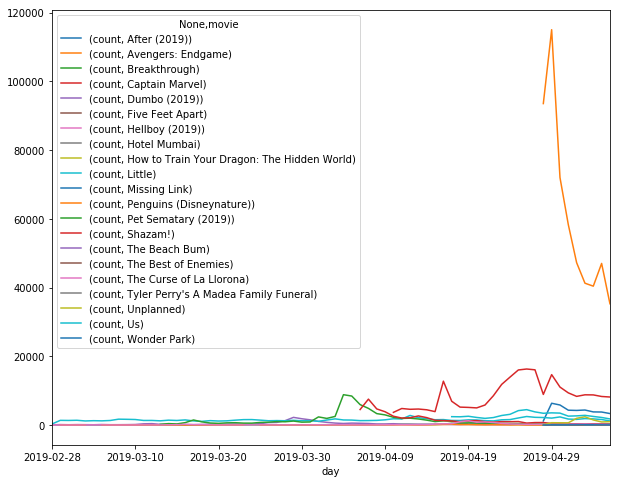

In [40]:
daysDF[["movie", "day", "count"]].pivot(index='day', columns='movie').plot(figsize = (10, 8))

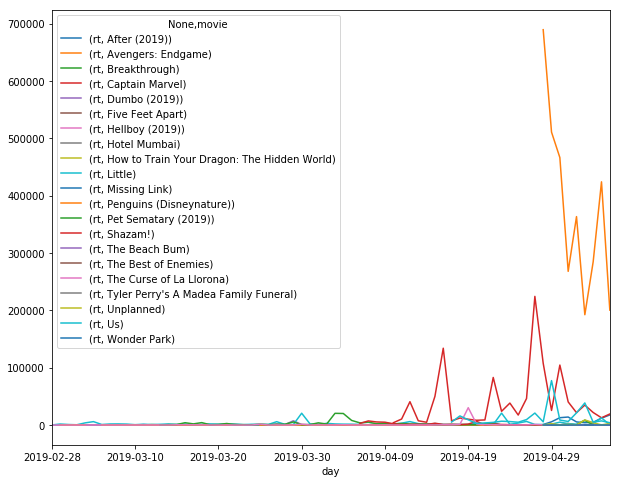

In [41]:
daysDF[["movie", "day", "rt"]].pivot(index='day', columns='movie').plot(figsize = (10, 8))

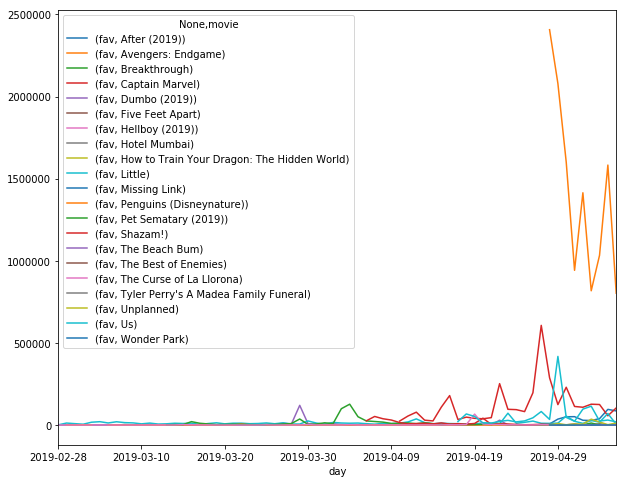

In [42]:
daysDF[["movie", "day", "fav"]].pivot(index='day', columns='movie').plot(figsize = (10, 8))

In [6]:
import nltk
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words("english"))
import re
    
def cleanText(y):
    x= y[1]
    x = x.lower()
    x =  re.sub(r'@[A-Za-z0-9]+','',x)
    x = re.sub('https?://[A-Za-z0-9./]+','',x)
    x = re.sub("[^a-zA-Z]", " ", x)
    x = re.sub( '\s+', ' ', x).strip()
    return [y[0] +"**"+ word for word in x.split() if word not in (stopwords_set) and len(word) > 3]

def cleanMovie(x):
    x = x.lower()
    x =  re.sub(r'@[A-Za-z0-9]+','',x)
    x = re.sub('https?://[A-Za-z0-9./]+','',x)
    x = re.sub("[^a-zA-Z]", " ", x)
    x = re.sub( '\s+', ' ', x).strip()
    return x.split()

In [7]:
wordsDF = df.groupBy("movie").agg(collect_list("text").alias("text")).rdd.map(lambda x: (x["movie"], " ".join(x["text"]))).flatMap(cleanText).map(lambda x: (x,1)).reduceByKey(lambda a,b: a+b).map(lambda x: {"movie" : x[0].split("**")[0], "word" : x[0].split("**")[1], "total" : x[1]}).toDF().toPandas()

/home/guiraiol/anaconda3/envs/idp/lib/python3.6/site-packages/pyspark/sql/session.py:366: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [8]:
for movie in wordsDF["movie"].unique():
    print(wordsDF[(wordsDF["movie"] == movie) & (~wordsDF["word"].str.contains("|".join(cleanMovie(movie) + ["movie", "pic", "twitter", "com"])))].sort_values("total", ascending = False).head(10))

#wordsDF[wordsDF["movie"] == "Avengers: Endgame"].sort_values("total", ascending = False)

               movie  total    word
286949  Dumbo (2019)   4860  disney
893127  Dumbo (2019)   1985  burton
968595  Dumbo (2019)   1968    live
761796  Dumbo (2019)   1875  action
342520  Dumbo (2019)   1842    like
362829  Dumbo (2019)   1732   watch
251752  Dumbo (2019)   1643  review
181050  Dumbo (2019)   1289    good
357679  Dumbo (2019)   1141  source
625537  Dumbo (2019)   1114   share
         movie  total      word
100756  Little  18507      like
428498  Little   9584     watch
928676  Little   8824      good
342668  Little   8214      time
772048  Little   7484      love
418522  Little   6451  watching
928675  Little   6412     think
90499   Little   6342      know
630789  Little   6234    really
110779  Little   5580     would
               movie  total      word
818112  After (2019)   5448   endgame
944302  After (2019)   5124      like
151268  After (2019)   4837  watching
555218  After (2019)   3733     watch
126189  After (2019)   3063      time
989227  After (2019)   2

                                             movie  total            word
322285  How to Train Your Dragon: The Hidden World    340        giveaway
393371  How to Train Your Dragon: The Hidden World    110            html
625526  How to Train Your Dragon: The Hidden World    110           enter
514610  How to Train Your Dragon: The Hidden World     93            pack
337433  How to Train Your Dragon: The Hidden World     82           httyd
817487  How to Train Your Dragon: The Hidden World     71            plus
660904  How to Train Your Dragon: The Hidden World     71          reader
756778  How to Train Your Dragon: The Hidden World     71        coloring
630603  How to Train Your Dragon: The Hidden World     71           pages
898127  How to Train Your Dragon: The Hidden World     65  kidsandacoupon
                                       movie  total     word
177819  Tyler Perry's A Madea Family Funeral      5  youtube
152497  Tyler Perry's A Madea Family Funeral      3    check
526

In [46]:
wordsDF[(wordsDF["movie"] == "Avengers: Endgame") & (~wordsDF["word"].str.contains("avengers|endgame"))].sort_values("total", ascending = False)

,movie,total,word
25291,Avengers: Endgame,162756,twitter
964201,Avengers: Endgame,149741,com
862158,Avengers: Endgame,113024,pic
328335,Avengers: Endgame,96669,de
422282,Avengers: Endgame,50329,marvel
274565,Avengers: Endgame,48867,game
693665,Avengers: Endgame,48315,end
172177,Avengers: Endgame,48292,que
867556,Avengers: Endgame,45066,la
855401,Avengers: Endgame,43305,movie
